# Inference notenook for [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

In [1]:
#@title Install
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git
!pip install youtube_dl

     |████████████████████████████████| 4.0 MB 10.0 MB/s 
     |████████████████████████████████| 596 kB 49.8 MB/s 
     |████████████████████████████████| 895 kB 32.0 MB/s 
     |████████████████████████████████| 6.5 MB 60.8 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-a2o2mp_7
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-a2o2mp_7
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=d0685de113c15015eea598af69b7ee4ad826cbcfed7e1ffc5795912b47f80e7b
  Stored in directory: /tmp/pip-ephem-wheel-cache-pe9s9e27/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
     |████████████████████████████████| 1

In [2]:
#@title Drive Downloader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}  

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

In [3]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image 


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')


In [4]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [5]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [7]:
#@title Choose pretrained model - COCO or Coneptual captions


pretrained_model = 'Conceptual captions'  # @param ['COCO', 'Conceptual captions']

if pretrained_model == 'Conceptual captions':
  downloader.download_file("14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT", model_path)
else:
  downloader.download_file("1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX", model_path)

In [8]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}  


In [9]:
#@title CLIP model + GPT2 tokenizer

device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 291MiB/s]


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [10]:
#@title Load model weights


prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
# DeepMind社のKineticsからYoutubeの動画を取得
# https://www.deepmind.com/open-source/kinetics
# https://qiita.com/shinkai_/items/7175215d7433b4cf150c

# Kineticsのデータをロード
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datas/kinetics700_2020/train.csv')
ids = df['youtube_id'].to_numpy()

# 取得する動画のURL群を準備
urls = []
for id in ids[2:10]:
  urls.append(f'https://www.youtube.com/watch?v={id}')

# Youtubeから動画を取得
from __future__ import unicode_literals
import youtube_dl
ydl_opts = {}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(urls)

[youtube] ---j12rm3WI: Downloading webpage
[youtube] ---j12rm3WI: Downloading MPD manifest
[download] Destination: SM2000 Automatic Pillow bag Vacuum Packaging Machine----j12rm3WI.f135.mp4
[download] 100% of 14.87MiB in 03:43
[download] Destination: SM2000 Automatic Pillow bag Vacuum Packaging Machine----j12rm3WI.f140.m4a
[download] 100% of 2.34MiB in 00:35
[ffmpeg] Merging formats into "SM2000 Automatic Pillow bag Vacuum Packaging Machine----j12rm3WI.mp4"
Deleting original file SM2000 Automatic Pillow bag Vacuum Packaging Machine----j12rm3WI.f135.mp4 (pass -k to keep)
Deleting original file SM2000 Automatic Pillow bag Vacuum Packaging Machine----j12rm3WI.f140.m4a (pass -k to keep)
[youtube] --07WQ2iBlw: Downloading webpage
[youtube] --07WQ2iBlw: Downloading MPD manifest
[download] Destination: Javelin standing throw drill---07WQ2iBlw.f137.mp4
[download] 100% of 3.28MiB in 00:42
[download] Destination: Javelin standing throw drill---07WQ2iBlw.f140.m4a
[download] 100% of 161.86KiB in 00

ERROR: This video has been removed for violating YouTube's Terms of Service


DownloadError: ignored

In [42]:
import cv2
from IPython.display import HTML
from base64 import b64encode

def save_all_frames(video_path, dir_path, basename, step, ext='jpg'):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    n_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    digit = len(str(n_frame))
    last_frame = n_frame - n_frame%step
    
    for i in range(0, n_frame+1, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            cv2.imwrite(f'{base_path}_{str(i).zfill(digit)}.{ext}', frame)
    return last_frame, digit

In [68]:
# ref: https://www.youtube.com/watch?v=mBNpx80-YxI
base_path = "/content/drive/MyDrive/Colab Notebooks/datas/"
video_path = "/content/rope climbing---0NTAs-fA0.mp4"  # ここを書き換える
dir_path = base_path + "temp"
basename = "sample_video_img"
step = 10

# フレーム毎に保存
last_frame, digit = save_all_frames(video_path, dir_path, basename, step)
last_frame

1160

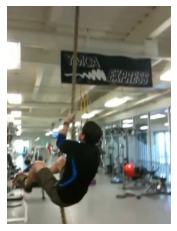

In [69]:
# あるフレームの図示
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
IMG_PATH = base_path + "temp/sample_video_img_0280.jpg"
plt.axis("off")
plt.imshow(Image.open(IMG_PATH))

Conceptual captions examples:
https://drive.google.com/file/d/1mzH3b0LQrGEWjEva4hI6HE_fIYRIgtBT/view?usp=sharing

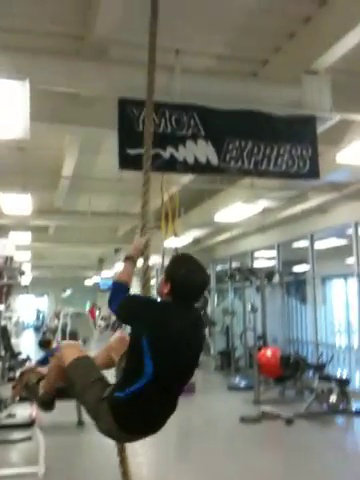

100%|██████████| 1/1 [00:00<00:00,  9.84it/s]



person, a student, has been training for years.


In [70]:
#@title Inference
use_beam_search = False #@param {type:"boolean"}  

image = io.imread(IMG_PATH)
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)

In [71]:
#@title 全フレームに対して推論
# 推論したキャプションは表示せずリストに格納
use_beam_search = False #@param {type:"boolean"}  

captions = []
for i in range(0, last_frame, step):
    IMG_PATH = f'{base_path}/temp/{basename}_{str(i).zfill(digit)}.jpg'

    image = io.imread(IMG_PATH)
    pil_image = PIL.Image.fromarray(image)

    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        # if type(model) is ClipCaptionE2E:
        #     prefix_embed = model.forward_image(image)
        # else:
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

    captions.append(generated_text_prefix)

100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


In [72]:
#@title 動画フレームにキャプションをつけた画像を作成・保存
save_dir = base_path + "result"
for i in range(0, last_frame, step):
    print(f'\r{i}/{last_frame}  {i/last_frame*100}%', end="")
    IMG_PATH = f'{base_path}/temp/{basename}_{str(i).zfill(digit)}.jpg'
    image = io.imread(IMG_PATH)

    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.title(captions[i//step])
    plt.imshow(image)
    plt.savefig(f'{save_dir}/{basename}_{str(i).zfill(4)}.jpg')
    plt.close()
    #plt.imsave(f'{save_dir}/{basename}_{str(i).zfill(4)}.jpg', image)

1150/1160  99.13793103448276%

In [73]:
#@title キャプション付きのgifを作成
import glob

# GIFアニメーションを作成・保存
def create_gif(in_dir, out_filename, duration=1000):
    path_list = sorted(glob.glob(os.path.join(*[in_dir, '*']))) # ファイルパスをソートしてリストする
    imgs = []                                                   # 画像をappendするための空配列を定義
 
    # ファイルのフルパスからファイル名と拡張子を抽出
    for i in range(len(path_list)):
        img = Image.open(path_list[i])                          # 画像ファイルを1つずつ開く
        imgs.append(img)                                        # 画像をappendで配列に格納していく
 
    # appendした画像配列をGIFにする。durationで持続時間、loopでループ数を指定可能。
    imgs[0].save(out_filename,
                 save_all=True, append_images=imgs[1:], optimize=False, duration=1000, loop=0)
    

in_dir = base_path + "result"
out_filename = base_path + "kinetics/kinetics4.gif"
create_gif(in_dir, out_filename)